# Voronoi diagram implementation in Python

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nfl-big-data-bowl-2020/train.csv
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/test.csv.encrypted
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/sample_submission.csv.encrypted
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/__init__.py
/kaggle/input/nfl-big-data-bowl-2020/kaggle/competitions/nflrush/competition.cpython-36m-x86_64-linux-gnu.so


### Importing data and libraries

In [2]:
train = pd.read_csv('../input/nfl-big-data-bowl-2020/train.csv')
train.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(509762, 49)

In [3]:
import numpy as np
import pandas as pd
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import matplotlib.path as path
import matplotlib as mpl
from scipy.spatial import Voronoi
import math
%matplotlib inline

### Handle Data:
- Creating on_offense variable (is player on offense?)
- Correcting team names
- Normalize X and Y
- Create Yards_from_own_goal variable
- Create player is Rusher variable

In [4]:
#correct the team names
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].replace('ARI','ARZ')
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].replace('ARI','ARZ')
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].replace('BAL','BLT')
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].replace('BAL','BLT')
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].replace('CLE','CLV')
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].replace('CLE','CLV')
train['VisitorTeamAbbr'] = train['VisitorTeamAbbr'].replace('HOU','HST')
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].replace('HOU','HST')

# Player is on offense
train['home_possession'] = (train['PossessionTeam'] == train['HomeTeamAbbr'])
train['team_binary'] = [True if i=="home" else False for i in train['Team']]
train['on_offense'] = (train['team_binary'] == train['home_possession'])

#correct X Y and Dir
mask = train["PlayDirection"] != "right"
train.loc[mask, "X"] = 120 - train.loc[mask, "X"]
train["X"] -= 10
train.loc[mask, "Y"] = 160/3 - train.loc[mask, "Y"]
train.loc[mask, "Dir"] = (train.loc[mask, "Dir"] + 180) % 360
train.loc[mask, "Orientation"] = np.mod(180 + train.loc[mask, 'Orientation'], 360)

#Yrds from own goal
train['YardsFromOwnGoal'] = train['YardLine']
train.loc[(train.FieldPosition!=train.PossessionTeam), 'YardsFromOwnGoal'] = (50 + (50 - train.loc[(train.FieldPosition!=train.PossessionTeam), 'YardsFromOwnGoal']))
train.loc[(train.YardLine==50), 'YardsFromOwnGoal'] = 50

#is Rusher
train['isRusher'] = (train['NflIdRusher'] == train['NflId'])

### Voronoi

Code to compute the regions and vertices

In [5]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius * 10

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def get_dx_dy(angle, dist):
    cartesianAngleRadians = (450-angle)*math.pi/180.0
    dx = dist * math.cos(cartesianAngleRadians)
    dy = dist * math.sin(cartesianAngleRadians)
    return dx, dy

Plot the points from player coordinates, and the voronoi polygons

In [6]:
#Sort values as subsets will be used in the code
train = train.sort_values(['on_offense','PlayId','isRusher'])

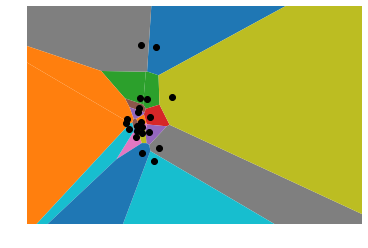

In [7]:
play = train[train.PlayId==20181007011551]
X = play['X']
Y = play['Y']

# make up data points
np.random.seed(1234)
points = np.c_[X, Y]

# compute Voronoi
vor = Voronoi(points)

# get regions and vertices (nodes)
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon))
    
plt.plot(points[:,0], points[:,1], 'o',color='black',zorder=1)

plt.ylim(0 ,57)
plt.xlim(0, 117)
plt.axis('off')

plt.show()

Add a color per team, and a different color and an arrow for the rusher (also adding the Yardline):
- Orange: Offensive players
- Red: Rusher
- Red arrow: direction of the rusher, and length proportional the speed
- Black: Players on defense
- Green: Yardline

Yards: 14


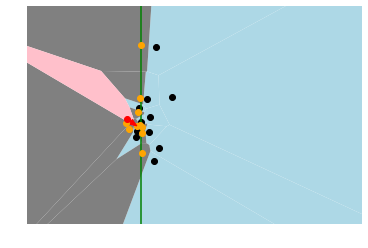

In [8]:
play = train[train.PlayId==20181007011551]
print('Yards:',play.Yards.iloc[0])
X = play['X']
Y = play['Y']

# make up data points
np.random.seed(1234)
points = np.c_[X, Y]

# compute Voronoi
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

# colorize
count=0
for region in regions:
    count+=1
    polygon = vertices[region]
    if count<12:#this is why we have sorted the dataframe before
        plt.fill(*zip(*polygon), "lightblue")
    elif count<22: 
        plt.fill(*zip(*polygon), "grey")
    else:
        plt.fill(*zip(*polygon), "pink")



plt.plot(points[:11,0], points[:11,1], 'o',color='black',zorder=1)#this is also the reason why we have sorted the dataframe before
plt.plot(points[11:21,0], points[11:21,1], 'o',color='orange',zorder=2)
plt.plot(points[21,0], points[21,1], 'o',color='red',zorder=3)

rusher_row = play[play.isRusher==True]
rusher_dir = rusher_row["Dir"].values[0]
rusher_speed = rusher_row["S"].values[0]
rusher_x = rusher_row["X"].values[0]
rusher_y = rusher_row["Y"].values[0]
dx, dy = get_dx_dy(rusher_dir, rusher_speed)
plt.arrow(rusher_x, rusher_y , dx, dy, width=.5, color='red',length_includes_head=True, zorder=4)

yardline = rusher_row["YardsFromOwnGoal"].values[0]
plt.vlines(yardline, 0, 60, color='green', linestyles='solid')

plt.ylim(0 ,57)
plt.xlim(0, 117)
plt.axis('off')

plt.show()

The first 20 plays

Yards: 8
20170907000118


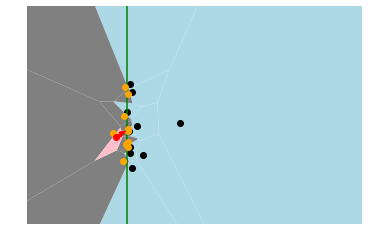

Yards: 3
20170907000139


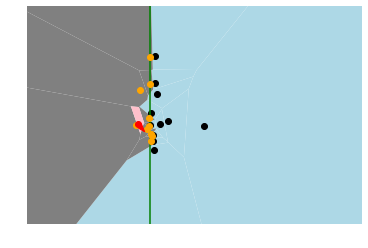

Yards: 5
20170907000189


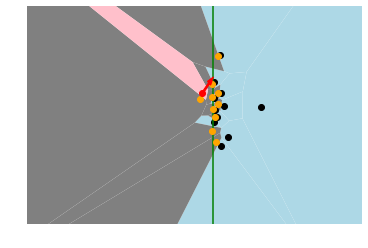

Yards: 2
20170907000345


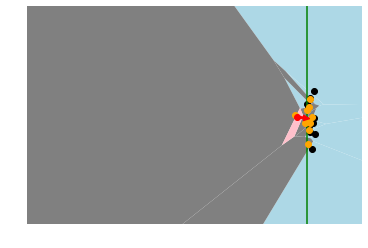

Yards: 7
20170907000395


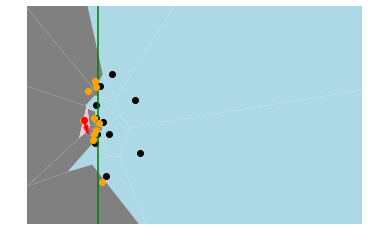

Yards: 10
20170907000473


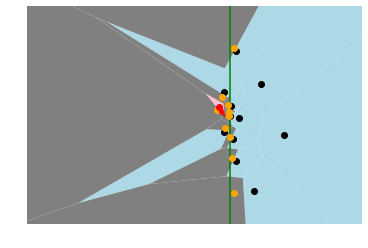

Yards: -1
20170907000516


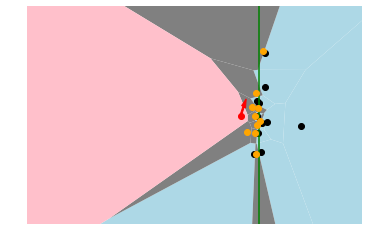

Yards: 0
20170907000653


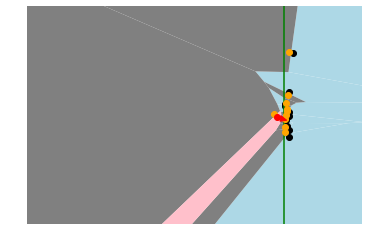

Yards: 9
20170907000680


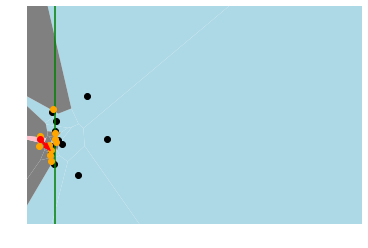

Yards: 9
20170907000801


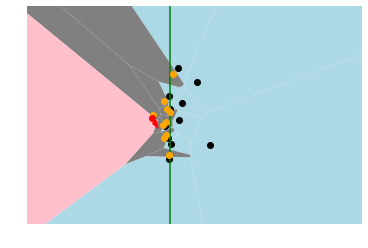

Yards: 2
20170907000917


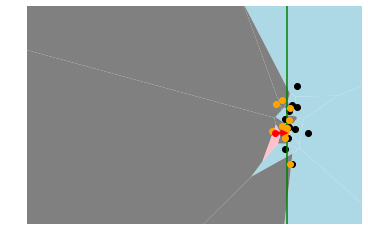

Yards: 3
20170907001004


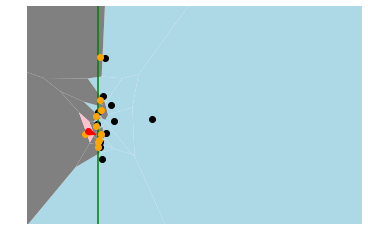

Yards: 13
20170907001077


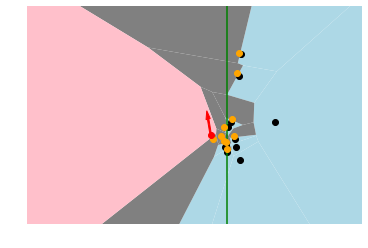

Yards: 4
20170907001156


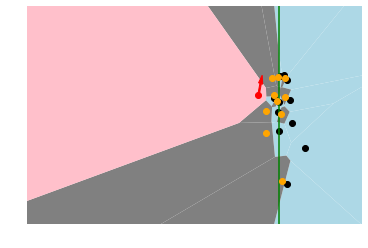

Yards: 0
20170907001177


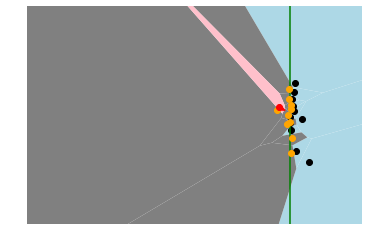

Yards: 4
20170907001296


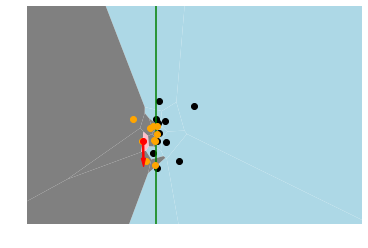

Yards: 4
20170907001355


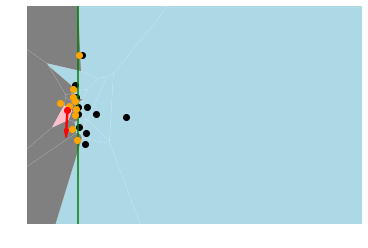

Yards: 4
20170907001376


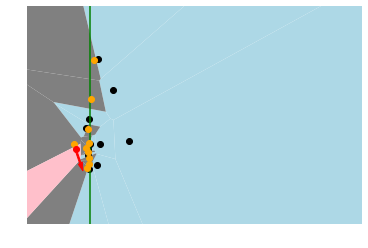

Yards: 0
20170907001443


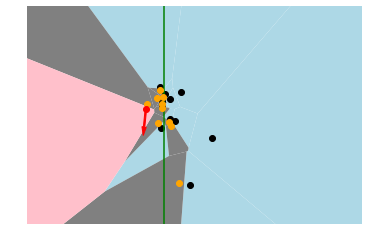

Yards: 16
20170907001488


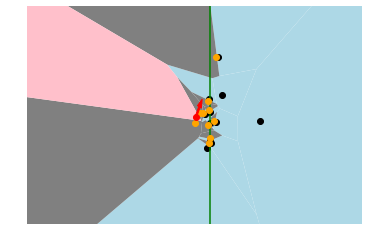

In [9]:
for i in train.PlayId.unique().tolist()[:20]:
    play = train[train.PlayId==i]
    print('Yards:',play.Yards.iloc[0])
    print(i)
    X = play['X']
    Y = play['Y']

    # make up data points
    np.random.seed(1234)
    points = np.c_[X, Y]

    # compute Voronoi
    vor = Voronoi(points)

    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor)

    # colorize
    count=0
    for region in regions:
        count+=1
        polygon = vertices[region]
        if count<12:
            plt.fill(*zip(*polygon), "lightblue")
        elif count<22: 
            plt.fill(*zip(*polygon), "grey")
        else:
            plt.fill(*zip(*polygon), "pink")



    plt.plot(points[:11,0], points[:11,1], 'o',color='black',zorder=1)
    plt.plot(points[11:21,0], points[11:21,1], 'o',color='orange',zorder=2)
    plt.plot(points[21,0], points[21,1], 'o',color='red',zorder=3)

    rusher_row = play[play.isRusher==True]
    rusher_dir = rusher_row["Dir"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    rusher_x = rusher_row["X"].values[0]
    rusher_y = rusher_row["Y"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)
    plt.arrow(rusher_x,rusher_y, dx,  dy,  width=.5, color='red',length_includes_head=True, zorder=4)
    
    yardline = rusher_row["YardsFromOwnGoal"].values[0]
    plt.vlines(yardline, 0, 60, color='green', linestyles='solid')

    plt.ylim(0 ,57)
    plt.xlim(0, 117)
    plt.axis('off')

    plt.show()
    